In [1]:
import pandas as pd
import numpy as np
from numpy import dtype
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('petfinder.csv')
df = df[df.Type == 'Dog'] 
df.drop(columns='Type', inplace=True)
cat_cols = df.columns[df.dtypes == 'object']
num_cols = df.columns[(~(df.dtypes == 'object')) & (df.columns != 'Adoption')]
print('Shape:', df.shape)
print('cat_cols:', list(cat_cols))
print('num_cols', list(num_cols))
label = 'Adoption'
ohe_df = df.copy(deep=True)

Shape: (10232, 18)
cat_cols: ['Name', 'Breed2', 'Gender', 'Color1', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'State', 'Description']
num_cols ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']


In [3]:
df.head(10)

,Name,Age,Breed2,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,Description,PhotoAmt,Adoption
2,yes,1,Mixed Breed,Male,Brown,Medium,Medium,Yes,Yes,No,Healthy,1,0,Selangor,0,yes,7.0,1
3,yes,4,Mixed Breed,Female,Black,Medium,Short,Yes,Yes,No,Healthy,1,150,Kuala Lumpur,0,yes,8.0,1
4,yes,1,Mixed Breed,Male,Black,Medium,Short,No,No,No,Healthy,1,0,Selangor,0,yes,3.0,1
7,yes,0,Mixed Breed,Female,Black,Medium,Short,No,No,No,Healthy,6,0,Selangor,0,yes,9.0,1
10,yes,2,Mixed Breed,Male,Black,Medium,Short,No,Yes,No,Healthy,1,0,Kuala Lumpur,0,yes,7.0,1
12,yes,2,Mixed Breed,Male,Brown,Medium,Long,Yes,Yes,No,Healthy,1,0,Selangor,0,yes,1.0,1
14,yes,3,Mixed Breed,Female,Brown,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Kuala Lumpur,0,yes,2.0,1
15,yes,78,Terrier,Male,Black,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Selangor,0,yes,2.0,0
17,yes,8,Mixed Breed,Female,Brown,Medium,Short,No,Yes,Yes,Healthy,1,10,Perak,0,yes,2.0,0
18,yes,2,Mixed Breed,Female,Black,Medium,Short,No,Yes,No,Healthy,1,0,Kuala Lumpur,0,yes,8.0,1


In [4]:
df.nunique().to_frame().T

,Name,Age,Breed2,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,Description,PhotoAmt,Adoption
0,2,106,124,3,7,4,3,3,3,3,3,19,67,14,9,2,31,2


In [5]:
pd.Series({col: df[col].unique() for col in df[cat_cols]})

Name                                                    [yes, no]
Breed2          [Mixed Breed, Terrier, Rottweiler, Shih Tzu, J...
Gender                                      [Male, Female, Mixed]
Color1          [Brown, Black, Gray, Cream, White, Golden, Yel...
MaturitySize                  [Medium, Large, Small, Extra Large]
FurLength                                   [Medium, Short, Long]
Vaccinated                                    [Yes, No, Not Sure]
Dewormed                                      [Yes, No, Not Sure]
Sterilized                                    [No, Not Sure, Yes]
Health                    [Healthy, Minor Injury, Serious Injury]
State           [Selangor, Kuala Lumpur, Perak, Johor, Pulau P...
Description                                             [yes, no]
dtype: object

In [6]:
df[label].value_counts()

1    5718
0    4514
Name: Adoption, dtype: int64

In [7]:
df[label].value_counts() / df.shape[0]

1    0.558835
0    0.441165
Name: Adoption, dtype: float64

#### Label Encoder

In [8]:
lbl_enc = {}
for col in cat_cols:
    lbl_enc[col] = LabelEncoder()
    lbl_enc[col].fit(df[col])

for col in cat_cols:
    df[col] = lbl_enc[col].transform(df[col])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=label), df[label], test_size=0.3, random_state=37, stratify=df[label])

#### Standard Scaler

In [10]:
scaler = StandardScaler()
scaler.fit(X_train[num_cols])

num_X_train = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
num_X_test = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

In [11]:
X_train = pd.concat([num_X_train, X_train[cat_cols]], axis=1)
X_test = pd.concat([num_X_test, X_test[cat_cols]], axis=1)

In [12]:
weights =dict((1 / y_train.value_counts()) * (len(y_train) * 2))
print(weights)

{1: 3.5792103948025984, 0: 4.5329113924050635}


### Model with embeddings

In [13]:
cat_dims = [int(df[col].nunique()) for col in cat_cols]
emb_size = [(x, min(50, (x + 1) // 2)) for x in cat_dims]

In [14]:
def emb_model(cat_cols, num_cols, emb_size):
    inputs = []
    outputs = []
    for cat, sz in zip(cat_cols, emb_size):
        _in = tf.keras.layers.Input(shape=(1,), name=f'in_{cat}')
        inputs.append(_in)
        _emb = tf.keras.layers.Embedding(sz[0], sz[1], 
                                          name=f'emb_{cat}')(_in)

        _emb_rshape = tf.keras.layers.Reshape(target_shape=(sz[1],),
                                              name=f'emb_rsh_{cat}')(_emb)
        outputs.append(_emb_rshape)


    num_in = tf.keras.layers.Input(shape=(len(num_cols),), name='in_num')
    inputs.append(num_in)
    outputs.append(num_in)
    x = tf.keras.layers.Concatenate()(outputs)
    x = tf.keras.layers.Dense(64, name='fc1', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5, name='drop1')(x)
    x = tf.keras.layers.Dense(64, name='fc2', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.8, name='drop2')(x)
    x = tf.keras.layers.Dense(1, name='pred', activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x, name='mlp_w_embeddings')
    return model

In [15]:
mlp_emb = emb_model(cat_cols, num_cols, emb_size)

In [16]:
metrics = 'accuracy'

In [17]:
mlp_emb.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=metrics)

In [18]:
def create_dataset(data, cat_cols, num_cols):
    input_vals = {}
    for cat in cat_cols:
        input_vals[f"in_{cat}"] = data[cat]
    input_vals["in_num"] = data[num_cols]
    return input_vals

In [19]:
train_ds = create_dataset(X_train, cat_cols, num_cols)
test_ds = create_dataset(X_test, cat_cols, num_cols)

In [20]:
results = mlp_emb.fit(train_ds, y_train, epochs=40, validation_data=(test_ds, y_test), verbose=0)

In [21]:
def results_to_df(results):
    hist = pd.DataFrame(results.history)
    hist['epoch'] = hist.index + 1
    return hist

def layer_name2idx(model, name):
    for idx, layer in enumerate(model.layers):
        if layer.name == name:
            return idx

In [22]:
hist = results_to_df(results)

In [23]:
def plot_learning_curves(hist, figsize=(20, 5), metrics=('accuracy', 'val_accuracy')):
    
    metric, val_metric=metrics
    fig, ax = plt.subplots(1, 2, figsize=figsize,
                           gridspec_kw=dict(width_ratios=[4, 5]))

    sns.lineplot(data=hist, x='epoch', y=metric, ax=ax[0], label=metric)
    sns.lineplot(data=hist, x='epoch', y=val_metric, ax=ax[0], label=val_metric)
    for ypos in ax[0].get_yticks():
        ax[0].axhline(ypos, color='black', alpha=0.1)
    ax[0].set_title('Training Epochs')

    zoom = hist.iloc[(hist.shape[0] // 3):hist.shape[0], :]
    sns.lineplot(data=zoom, x='epoch', y=metric, ax=ax[1], label=metric)
    sns.lineplot(data=zoom, x='epoch', y=val_metric, ax=ax[1], label=val_metric)
    for ypos in ax[1].get_yticks():
        ax[1].axhline(ypos, color='black', alpha=0.1)
    ax[1].set_title('Training Epochs - Zoomed')
    ax[1].get_legend().remove()

    sns.despine(offset=10)
    plt.show()

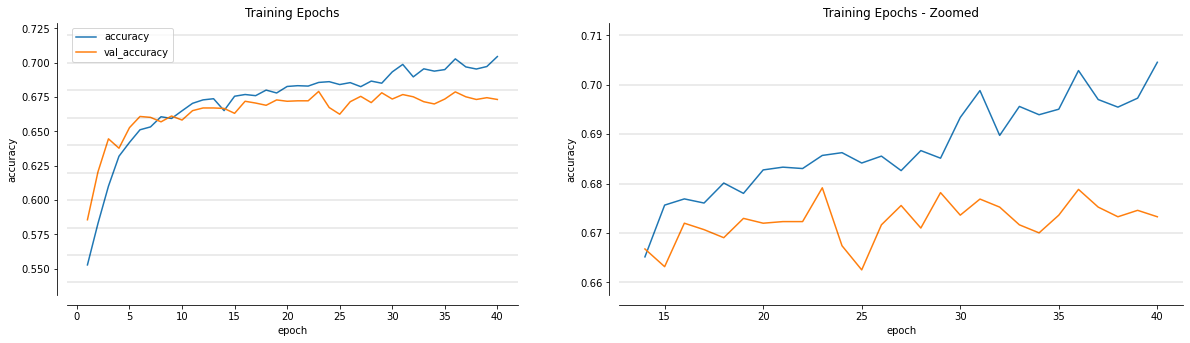

In [24]:
plot_learning_curves(hist, metrics=('accuracy', 'val_accuracy'))

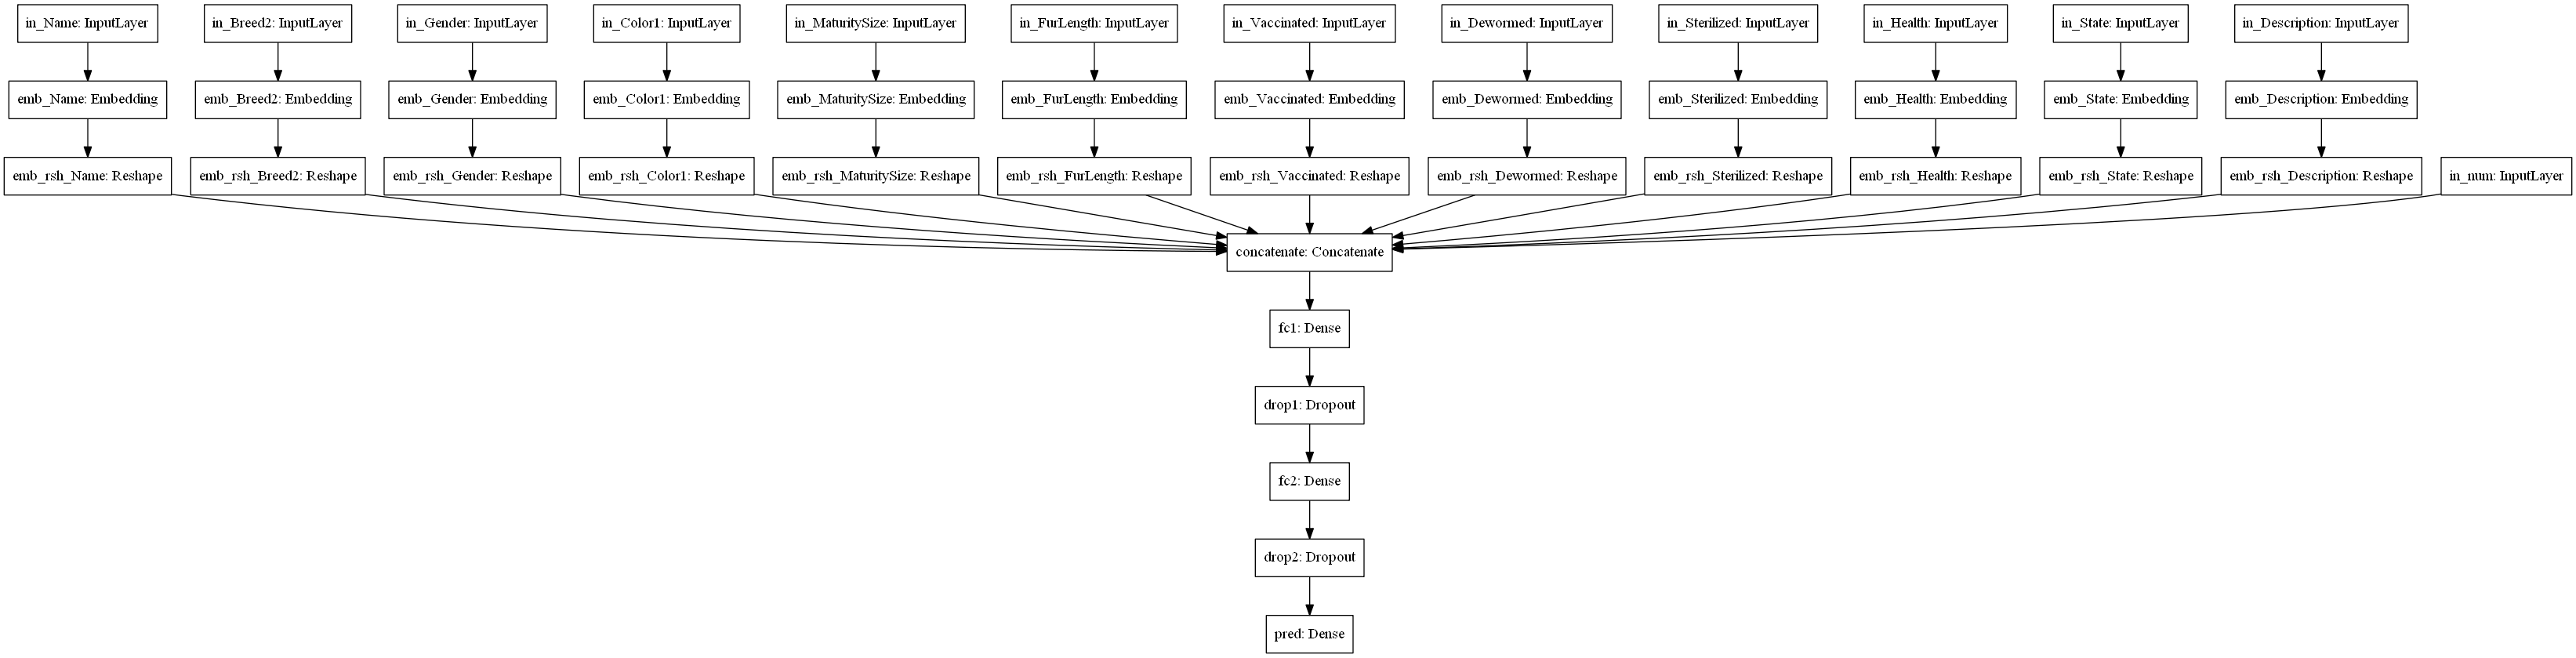

In [25]:
tf.keras.utils.plot_model(mlp_emb, expand_nested=True, to_file='emb_classifier.png')

In [26]:
mlp_emb.summary()

Model: "mlp_w_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_Name (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
in_Breed2 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
in_Gender (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
in_Color1 (InputLayer)          [(None, 1)]          0                                            
___________________________________________________________________________________

### Embeddings

In [27]:
name = 'Breed2'
layer_idx = layer_name2idx(mlp_emb, 'emb_'+name)
emb = mlp_emb.layers[layer_idx].get_weights()[0]
print('Embedding Shape:', emb.shape)
emb = pd.DataFrame(emb)
emb.index = lbl_enc[name].inverse_transform(emb.index)

Embedding Shape: (124, 50)


In [28]:
emb.head(10)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.293521,-0.286695,0.279160,-0.341397,-0.108289,-0.100574,-0.296929,0.031702,-0.053201,-0.288527,...,-0.268396,-0.081174,-0.033006,0.000615,0.112484,0.084393,-0.075468,-0.173947,0.228847,0.308075
Affenpinscher,0.320656,-0.411303,0.027847,-0.278810,-0.113616,-0.325262,-0.002800,-0.413419,0.087872,-0.267274,...,0.269059,0.156859,-0.333084,0.028553,0.345312,-0.169405,-0.191470,-0.304463,-0.295303,0.101235
Afghan Hound,0.314001,-0.429307,0.087703,-0.245193,-0.179585,-0.187013,-0.098984,-0.313442,0.293449,-0.303394,...,0.146982,0.092060,-0.277797,0.198465,0.275052,-0.106390,-0.105601,-0.345010,-0.172643,0.204047
Airedale Terrier,0.245825,-0.241886,0.003706,-0.189458,-0.116776,-0.234741,0.086859,-0.404877,0.065925,-0.182075,...,0.250243,0.111355,-0.127863,-0.046116,0.247953,-0.198051,-0.001856,-0.276821,-0.260928,0.069380
Akita,0.158975,0.077995,0.009555,-0.237212,-0.167698,0.131689,-0.132200,0.171282,-0.096064,-0.292911,...,-0.203555,0.061057,0.054725,-0.025127,-0.232333,0.044040,0.149487,0.077570,0.215276,0.288431
American Bulldog,0.374791,-0.329497,0.162644,-0.320672,-0.201758,-0.310237,-0.118144,-0.396071,0.114503,-0.204699,...,0.213519,0.179392,-0.407356,0.115803,0.309113,-0.163687,-0.117171,-0.321731,-0.362894,0.113219
American Staffordshire Terrier,-0.324202,0.332894,-0.255132,0.200137,-0.061192,0.171757,-0.171807,0.249322,-0.196076,-0.097748,...,0.184039,-0.068768,0.160393,-0.343964,-0.203952,0.180746,0.032709,0.248357,0.086860,-0.101575
American Water Spaniel,0.406010,-0.357809,-0.173444,-0.100932,-0.151049,-0.453858,0.020001,-0.499750,0.050992,-0.235075,...,0.303575,-0.124564,-0.313249,0.207685,0.406817,-0.310681,-0.209533,-0.412421,-0.322690,0.059260
Australian Kelpie,-0.144653,-0.064154,-0.077389,0.061217,-0.119274,-0.143283,0.095051,-0.041709,0.031761,0.033788,...,0.073579,0.002685,-0.000811,0.114170,0.061823,0.027776,0.085595,-0.019924,0.040699,-0.108536
Australian Shepherd,-0.013518,0.002907,-0.009045,-0.028458,-0.015633,-0.014891,-0.007593,-0.034575,-0.023798,-0.016593,...,0.010055,0.007120,-0.022812,-0.015242,0.009384,-0.017092,-0.002332,-0.019467,-0.004761,0.033529


In [29]:
pca = PCA()
pca.fit(emb)
print(pca.explained_variance_ratio_.cumsum()[0:5])

[0.568024   0.757159   0.8141048  0.84149605 0.86055523]


In [30]:
pca = PCA(n_components=2)
emb2dim = pd.DataFrame(pca.fit_transform(emb), index=emb.index, columns=['PC1', 'PC2'])

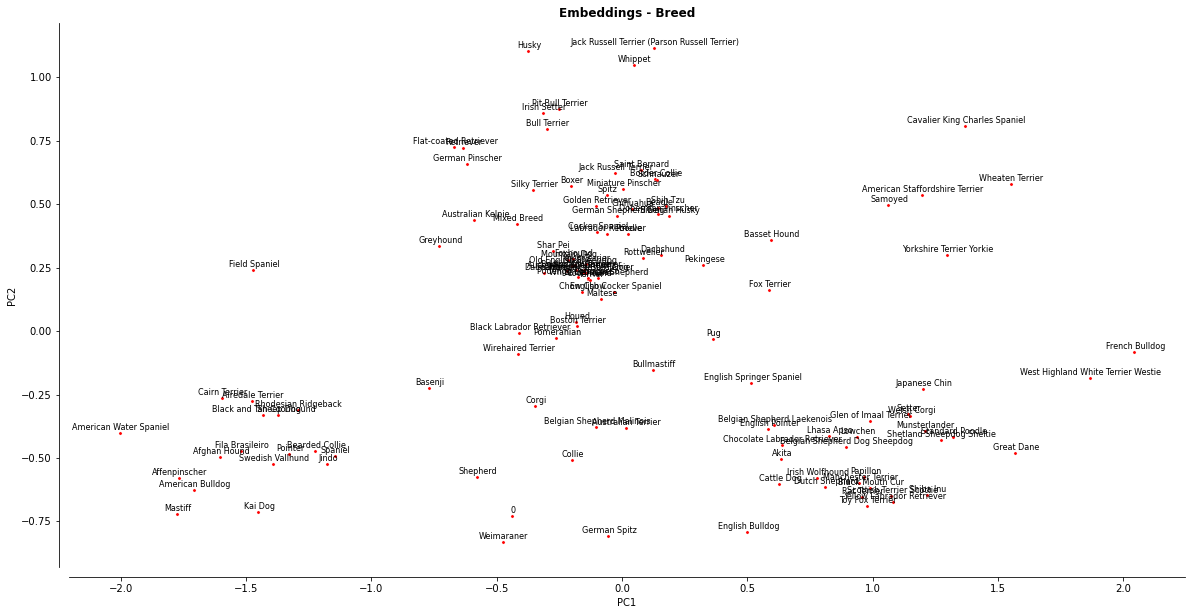

In [31]:
fig, ax = plt.subplots(figsize=(20, 10), facecolor='white')
sns.scatterplot(data=emb2dim, x='PC1', y='PC2', ax=ax, s=10, color='red')
for row in range(len(emb2dim)):
    txt = emb2dim.index[row]
    x = emb2dim.iloc[row, 0]
    y = emb2dim.iloc[row, 1]
    ax.annotate(txt, (x, y), ha='center', fontsize=8, 
                xytext=(1, 3), textcoords='offset points')
sns.despine(offset=10)
ax.set_title('Embeddings - Breed', weight='bold')
plt.show()

In [32]:
pred_result = X_test.copy(deep=True)
pred_result['real'] = y_test
pred_result['pred'] = np.round(mlp_emb.predict(test_ds)).astype(int)

In [33]:
pred_result

,Age,Quantity,Fee,VideoAmt,PhotoAmt,Name,Breed2,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,State,Description,real,pred
13022,-0.332913,-0.346843,-0.290852,-0.161668,-0.786455,1,54,1,0,2,2,2,2,0,0,12,1,1,1
804,-0.563193,0.305320,-0.290852,-0.161668,-0.190414,1,79,0,1,2,2,0,0,0,0,12,1,0,1
8532,-0.517137,-0.346843,-0.290852,-0.161668,-0.488435,1,79,0,1,2,2,2,2,0,0,12,1,1,1
2998,-0.517137,-0.346843,-0.290852,-0.161668,-0.488435,0,79,0,0,2,1,0,0,0,0,3,1,1,1
11057,-0.471081,0.957483,-0.290852,-0.161668,-0.190414,1,79,2,0,2,2,0,0,0,0,12,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18831,0.726376,-0.346843,-0.290852,-0.161668,-0.190414,1,79,1,1,2,2,2,2,0,0,12,1,0,0
15371,-0.471081,-0.346843,-0.290852,-0.161668,-0.190414,1,79,0,2,2,2,2,2,0,0,12,1,0,1
13676,-0.056577,-0.346843,-0.290852,-0.161668,-0.786455,1,30,0,1,2,2,0,0,2,0,12,1,0,0
15519,-0.471081,-0.346843,-0.290852,-0.161668,-0.488435,1,79,0,0,2,2,2,2,0,0,6,1,0,0


In [34]:
mlp_emb.evaluate(test_ds, y_test)

96/96 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6733


[0.6546691060066223, 0.6732898950576782]